# segmentation modelsやalbumentationsをインストールしていないときは実行する．

In [1]:
#!pip install segmentation-models-pytorch

In [ ]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

## TrainおよびValファイルの準備

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

import glob
from PIL import Image

In [3]:
DATA_DIR = '../image/train/'

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train_images')
y_train_dir = os.path.join(DATA_DIR, 'train_gt')


x_train_files = glob.glob(x_train_dir +'/*')
y_train_files = glob.glob(y_train_dir +'/*')



In [6]:
len(x_train_files)

57600

In [5]:
x_valid_dir = os.path.join(DATA_DIR, 'val_images')
y_valid_dir = os.path.join(DATA_DIR, 'val_gt')

y_train_files = glob.glob(y_train_dir +'/*')
y_val_files = glob.glob(y_valid_dir +'/*')

In [ ]:
len(y_val_files)

## Datasetの作成

In [2]:
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name GeForce GTX 1070


In [29]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [28]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [30]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'building'] #変更
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

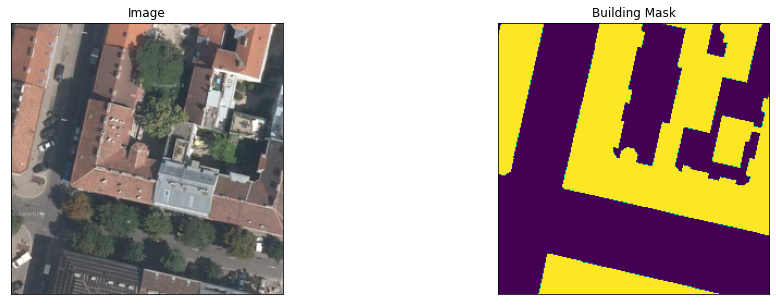

In [31]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['building'])

image, mask = dataset[6] # get some sample
visualize(
    image=image, 
    building_mask=mask.squeeze(),
)

In [32]:
import albumentations as albu

In [33]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

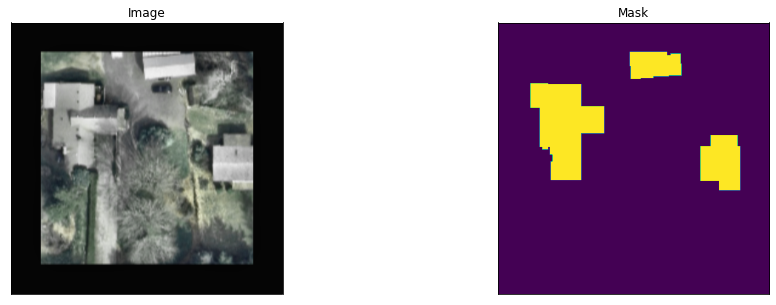

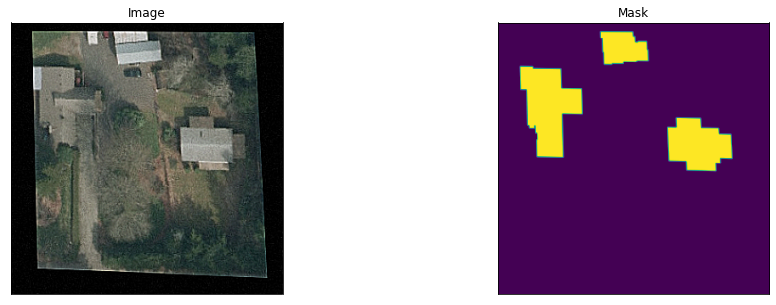

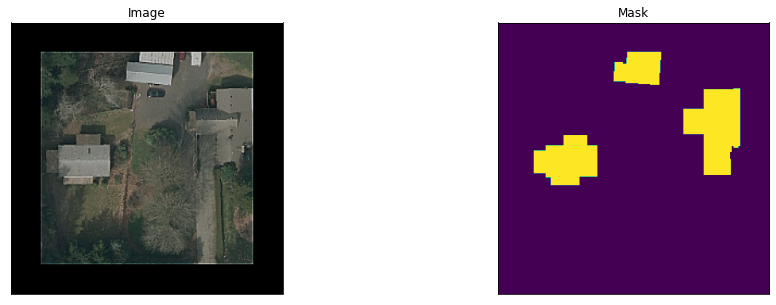

In [34]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['building'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[8]
    #print(image.shape)
    visualize(image=image, mask=mask.squeeze(-1))

In [35]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [36]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [37]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [38]:

# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [39]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [40]:
# train model for 40 epochs

max_score = 0


#train accurascy, train loss, val_accuracy, val_loss をグラフ化できるように設定．
x_epoch_data = []
train_dice_loss = []
train_iou_score = []
valid_dice_loss = []
valid_iou_score = []


for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_Unet_resnet50.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 14400/14400 [06:22<00:00, 37.68it/s, dice_loss - 0.4645, iou_score - 0.4946]
Model saved!

Epoch: 1
valid: 100%|██████████| 14400/14400 [06:17<00:00, 38.13it/s, dice_loss - 0.4328, iou_score - 0.4926]

Epoch: 2
valid: 100%|██████████| 14400/14400 [05:52<00:00, 40.86it/s, dice_loss - 0.424, iou_score - 0.5519] 
Model saved!

Epoch: 3
valid: 100%|██████████| 14400/14400 [05:50<00:00, 41.08it/s, dice_loss - 0.3894, iou_score - 0.5373]

Epoch: 4
valid: 100%|██████████| 14400/14400 [06:18<00:00, 38.02it/s, dice_loss - 0.3604, iou_score - 0.5668]
Model saved!

Epoch: 5
valid: 100%|██████████| 14400/14400 [06:25<00:00, 37.38it/s, dice_loss - 0.4213, iou_score - 0.5309]

Epoch: 6
valid: 100%|██████████| 14400/14400 [05:50<00:00, 41.07it/s, dice_loss - 0.3567, iou_score - 0.571] 
Model saved!

Epoch: 7
valid: 100%|██████████| 14400/14400 [05:50<00:00, 41.12it/s, dice_loss - 0.3498, iou_score - 0.5633]

Epoch: 8
valid: 100%|██████████| 14400/14400 [05:52<00:00, 

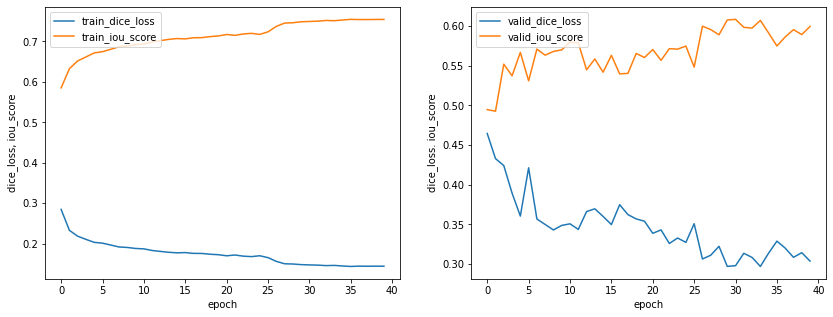

In [41]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train_dice_loss') 
line2, = ax1.plot(x_epoch_data,train_iou_score,label='train_iou_score')
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss, iou_score')
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(1, 2, 2)
line1, = ax2.plot(x_epoch_data,valid_dice_loss,label='valid_dice_loss') 
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='valid_iou_score') 
ax2.set_xlabel('epoch')
ax2.set_ylabel('dice_loss. iou_score')
ax2.legend(loc='upper left')

plt.show()

In [42]:
# load best saved checkpoint
best_model = torch.load('./best_model_Unet_resnet50.pth')

In [43]:
best_model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): C

In [44]:
# create test dataset
test_dataset = Dataset(
    x_valid_dir, #x_test_dir
    y_valid_dir, #y_test_dir
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [45]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 14400/14400 [07:47<00:00, 30.81it/s, dice_loss - 0.2978, iou_score - 0.6085]


In [46]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_valid_dir, y_valid_dir, #x_test_dir, y_test_dir,
    classes=CLASSES,
)

In [47]:
# test dataset without transformations for image visualization
test_dataset_vis2 = Dataset(
    x_valid_dir, y_valid_dir, #x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

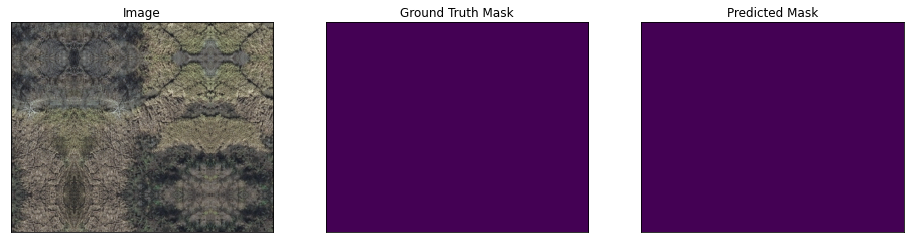

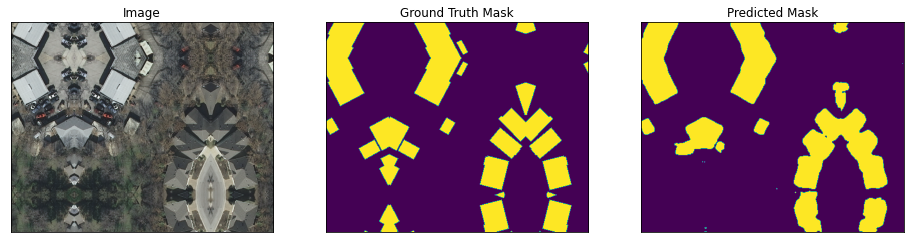

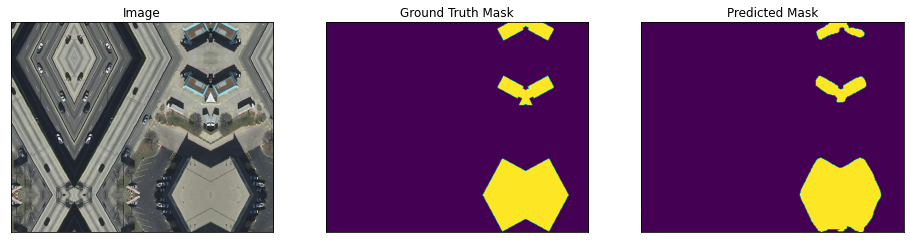

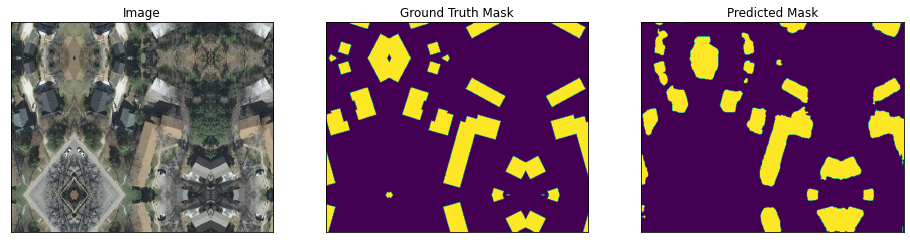

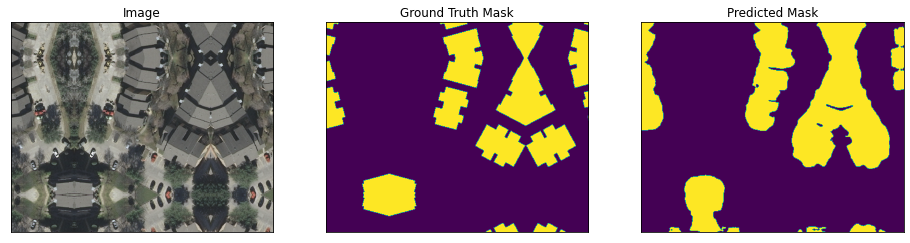

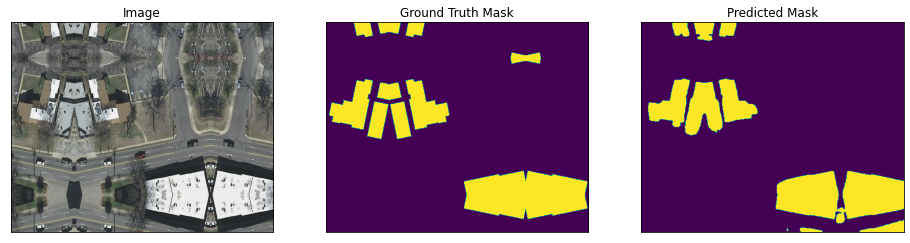

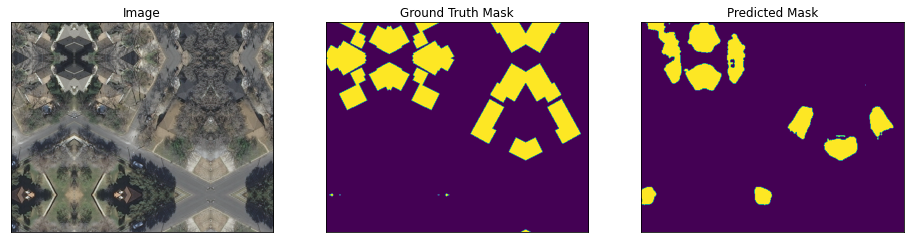

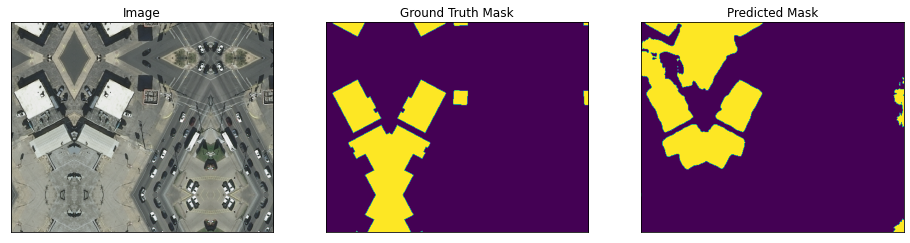

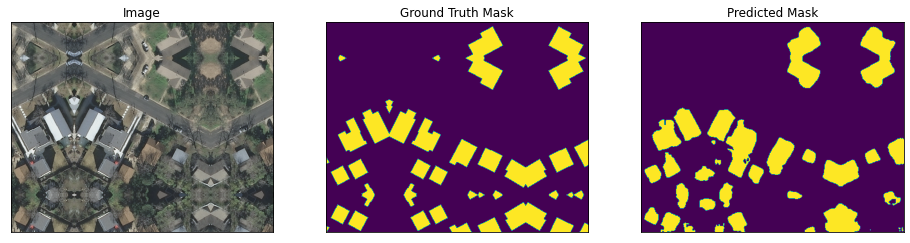

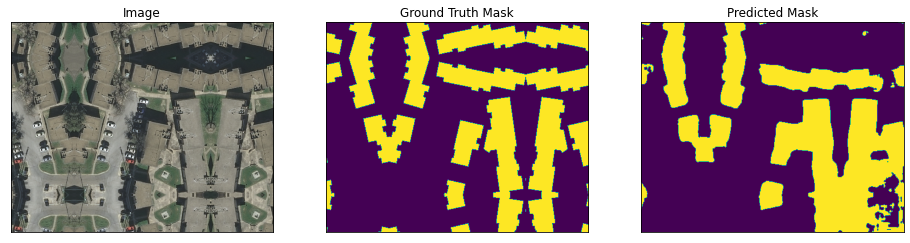

In [48]:
for i in range(10):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis2[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )